# CNN 심화

## [예제7] Grad-CAM 구현

> ### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


>### Load modules

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.18.5
TensorFlow Version :2.3.0
Matplotlib Version :3.2.2


> ### Load VGG16 Model

In [3]:
from tensorflow.keras.applications import VGG16

model = VGG16(weights="imagenet")

model.summary() 

553467904/553467096 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

> ### Summarize Filter Shape

> ### Prepare Test Image

(1, 224, 224, 3)


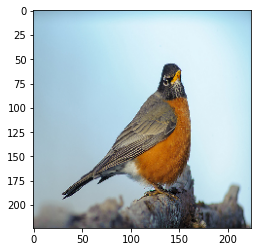

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

img_path = '/content/drive/My Drive/files/images/bird.jpg'
img = image.load_img(img_path, target_size=(224, 224)) # 파일을 이미지로 로딩
plt.imshow(img)                                        # 이미지 그리기
img = image.img_to_array(img)                          # 이미지를 ndarray로 변경: (224,224,3)
img = np.expand_dims(img, axis=0)                      # 차원 확장: (1,224,224,3)
img = preprocess_input(img)                            # VGG-16 모델 입력에 맞도록 전처리
print(img.shape)

> ### Prediction

In [5]:
from keras.applications.vgg16 import decode_predictions
preds = model.predict(img)
predict_result = decode_predictions(preds, top=2)
print('decode_predictions:\n ==>', predict_result)
print('Predicted:', predict_result[0][0][1])

40960/35363 [==================================] - 0s 0us/step
decode_predictions:
 ==> [[('n01558993', 'robin', 0.99951136), ('n04604644', 'worm_fence', 0.00045578144)]]
Predicted: robin


> ### Define Model

In [6]:
model_grad = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('block5_conv3').output, model.output]
)

> ### Build CAM

In [7]:
with tf.GradientTape() as tape:
    conv_outputs, predict = model_grad(img) # 모델을 돌려서 output 2개 출력
    class_out = predict[:, np.argmax(predict[0])] # 타겟 Class 번호

output = conv_outputs[0] # 타겟 Feature map
grads = tape.gradient(class_out, conv_outputs)[0] # 편미분 결과
print(grads.shape, output.shape)

(14, 14, 512) (14, 14, 512)


In [8]:
weights = tf.reduce_mean(grads, axis=(0, 1)) # GAP 연산
cam = np.ones(output.shape[0:2], dtype=np.float32) # CAM 초기화

for index, w in enumerate(weights):
    cam += w * output[:, :, index] # Grad-CAM 연산

print(cam.shape, weights.shape)

(14, 14) (512,)


> ### Get the image with cv2

((426, 640, 3), numpy.ndarray)

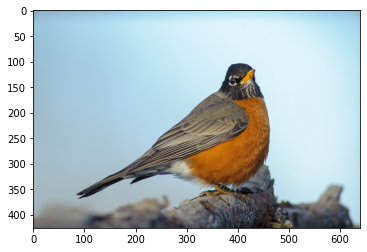

In [9]:
import cv2

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

img.shape, type(img)

> ### Build Heat map

(426, 640, 3)


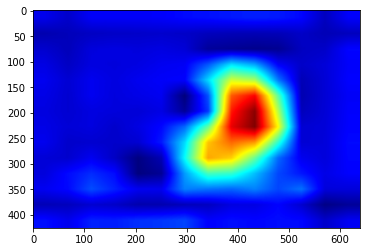

In [10]:
cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
cam = np.maximum(cam, 0) # ReLU 연산: 0 이하는 0, 0 이상은 그대로
heatmap = (cam - cam.min()) / (cam.max() - cam.min()) # 0 ~ 1로 변환
heatmap = np.uint8(255 * heatmap) # 0 ~ 255로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Color map 적용
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # BGR을 RGB로

plt.imshow(heatmap)
print(heatmap.shape)

> ### Blending heatmap on image

In [11]:
output_image = cv2.addWeighted(img.astype('uint8'), 1, # 이미지 100%
                               heatmap, 0.5,           # heatmap 50%
                               0)

Text(0.5, 1.0, 'robin')

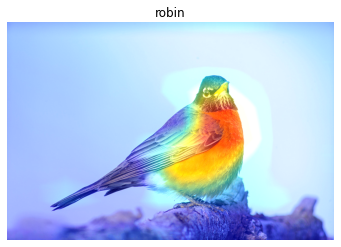

In [12]:
plt.imshow(output_image)
plt.axis('off')
plt.title(decode_predictions(preds, top=2)[0][0][1])